In [1]:
from scipy.stats import f_oneway
from scipy.stats import kruskal

import pandas as pd
import numpy as np
import tellurium as te

import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import os

import gzip
import cloudpickle

In [2]:
os.chdir('..')
from src import util
os.chdir('notebooks')

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Visualizing Spearman data 

### Condense Spearman data

In [3]:
os.chdir('../data/results/spearman_coefficients/')

In [4]:
spr_file_list = [i for i in os.listdir() if "topologyB" in i]

spr_dfs = []
for file in spr_file_list:
    a = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    spr_dfs.append(a)

all_spr_df_B = pd.concat(spr_dfs)
all_spr_df_B

,Unnamed: 0,r,p-value,lower,upper,reg,omit
0,0.1x,0.760578,2.479065e-04,0.357387,0.923009,noReg,allData
1,0.2x,0.857585,5.389260e-06,0.637825,0.965690,noReg,allData
2,0.3x,0.905057,2.455886e-07,0.719650,0.987409,noReg,allData
3,0.4x,0.896801,4.658861e-07,0.686751,0.983230,noReg,allData
4,0.5x,0.878225,1.648270e-06,0.653140,0.977014,noReg,allData
...,...,...,...,...,...,...,...
6,1.5x,0.550052,1.802759e-02,0.109891,0.799593,reg2,omitIntMet
7,3x,0.822497,2.792617e-05,0.516178,0.937359,reg2,omitIntMet
8,5x,0.818369,3.310307e-05,0.532179,0.918752,reg2,omitIntMet
9,7x,0.611971,6.950275e-03,0.250293,0.800229,reg2,omitIntMet


In [5]:
os.chdir('../../../notebooks/')

In [6]:
all_spr_df_B.rename(columns={'Unnamed: 0':'perturbation'}, inplace=True)
all_spr_df_B['perturbation'] = [float(i.split('x')[0]) for i in all_spr_df_B['perturbation']]

In [7]:
all_spr_df_B = all_spr_df_B[all_spr_df_B['perturbation'] != 1.01]

In [8]:
b = all_spr_df_B.pivot(index=['omit', 'reg'], columns='perturbation', values='r')
b

perturbation           0.1       0.2       0.3       0.4       0.5       1.5   \
omit        reg                                                                 
allData     noReg  0.760578  0.857585  0.905057  0.896801  0.878225  0.925697   
            reg1   0.669763  0.853457  0.892673  0.913313  0.927761  0.909185   
            reg2   0.644995  0.830753  0.822497  0.869969  0.812178  0.855521   
omitEnzymes noReg  0.415893  0.351909  0.554180  0.475748  0.366357  0.331269   
            reg1   0.543860  0.238390  0.597523  0.263158  0.376677  0.405573   
            reg2   0.593395  0.368421  0.583075  0.415893  0.731682  0.671827   
omitExMet   noReg  0.902993  0.950464  0.940144  0.940144  0.940144  0.975232   
            reg1   0.909185  0.822497  0.855521  0.915377  0.853457  0.958720   
            reg2   0.787410  0.818369  0.867905  0.892673  0.855521  0.936017   
omitFluxes  noReg -0.172343 -0.114551 -0.188854 -0.073271  0.246646  0.426213   
            reg1  -0.155831  0.141383 -0.085655 -0.005160  0.060888  0.413829   
            reg2  -0.298246  0.207430  0.023736 -0.042312  0.180599  0.263158   
omitIntMet  noReg  0.062951  0.116615  0.062951  0.380805 -0.025800  0.547988   
            reg1  -0.042312  0.296182  0.399381  0.605779  0.172343  0.554180   
            reg2   0.234262  0.054696  0.250774  0.566563  0.403509  0.550052   

perturbation           3.0       5.0       7.0       10.0  
omit        reg                                            
allData     noReg  0.869969  0.863777  0.845201  0.847265  
            reg1   0.857585  0.851393  0.878225  0.869969  
            reg2   0.830753  0.857585  0.847265  0.865841  
omitEnzymes noReg  0.368421  0.479876  0.405573  0.432405  
            reg1   0.560372  0.256966  0.525284  0.403509  
            reg2   0.609907  0.413829  0.541796  0.432405  
omitExMet   noReg  0.917441  0.880289  0.843137  0.789474  
            reg1   0.880289  0.878225  0.814241  0.735810  
            reg2   0.894737  0.853457  0.826625  0.739938  
omitFluxes  noReg -0.077399 -0.071207  0.300310  0.339525  
            reg1   0.091847 -0.056760  0.236326  0.306502  
            reg2   0.031992 -0.108359  0.153767  0.333333  
omitIntMet  noReg  0.752322  0.777090  0.673891  0.632611  
            reg1   0.882353  0.665635  0.275542 -0.005160  
            reg2   0.822497  0.818369  0.611971  0.302374

In [9]:
fluxes_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitFluxes']))]
enzymes_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitEnzymes']))]
intMet_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitIntMet']))]
exMet_comp = all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2') & (all_spr_df_B['omit'].isin(['none', 'omitExMet']))]

### All-in-one scatter plots

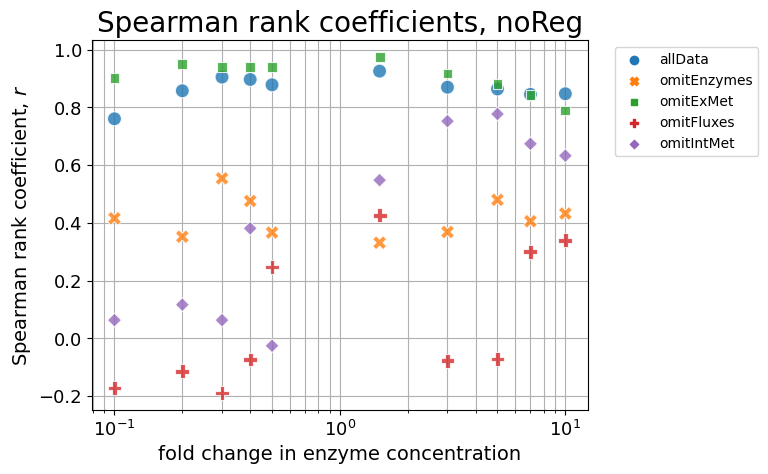

In [12]:
util.plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='noReg')], 'Spearman rank coefficients, noReg')

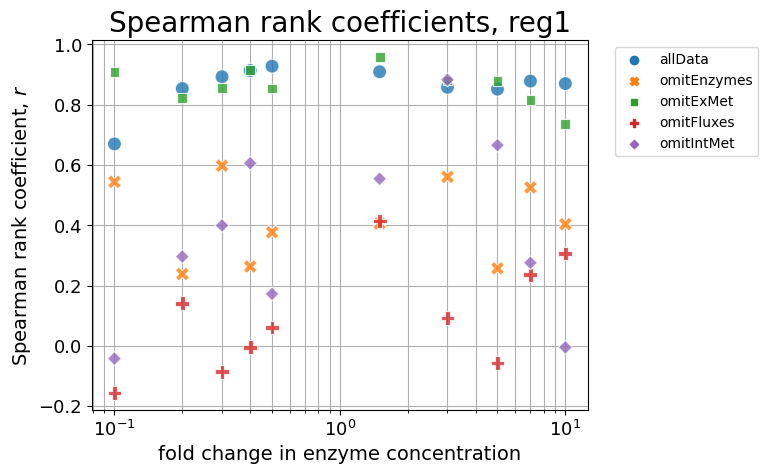

In [11]:
util.plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg1')], 'Spearman rank coefficients, reg1')

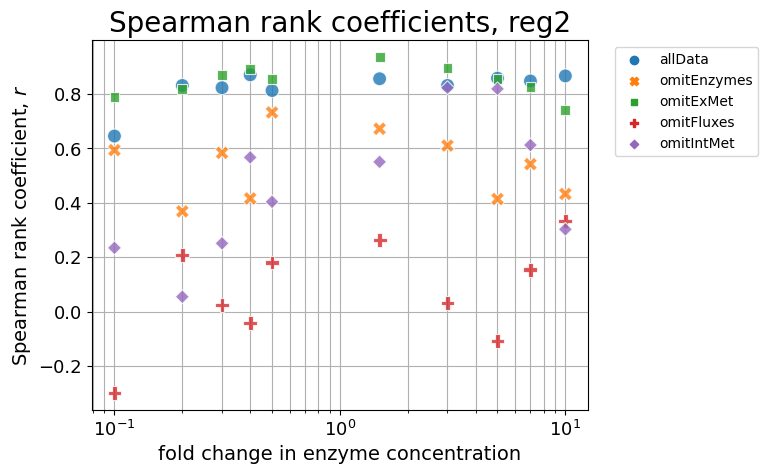

In [13]:
util.plt_spr_scatter(all_spr_df_B.loc[(all_spr_df_B['reg'] =='reg2')], 'Spearman rank coefficients, reg2')

## Visualizing MAE across the different types of data

In [18]:
os.chdir('../data/results/MAE/')
MAE_file_list = [i for i in os.listdir() if "topologyB" in i]

MAE_dfs = []
for file in MAE_file_list:
    b = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    b['reg'] = [reg]*len(b)
    b['omit'] = [omit]*len(b)
    MAE_dfs.append(b)

all_MAE_df_B = pd.concat(MAE_dfs)
all_MAE_df_B

os.chdir('../../../notebooks/')


In [19]:
all_MAE_df_B.columns = ['perturbation', 'values', 'reg', 'omit']
all_MAE_df_B['values'] = all_MAE_df_B['values']/247
all_MAE_df_B

,perturbation,values,reg,omit
0,gt,0.000000,noReg,allData
1,0.1x,0.194806,noReg,allData
2,0.2x,0.198440,noReg,allData
3,0.3x,0.182855,noReg,allData
4,0.4x,0.187550,noReg,allData
...,...,...,...,...
6,1.5x,0.511912,reg2,omitIntMet
7,3x,0.496715,reg2,omitIntMet
8,5x,0.499787,reg2,omitIntMet
9,7x,0.505920,reg2,omitIntMet


In [20]:
# a = all_MAE_df_B.pivot(index=['omit', 'reg'], columns='perturbation', values='values')

all_MAE_df_B = all_MAE_df_B[all_MAE_df_B['perturbation'] != 1.01]
all_MAE_df_B = all_MAE_df_B[all_MAE_df_B['perturbation'] != 'knockout']


C:\Users\user\AppData\Local\Temp\ipykernel_30616\3621013563.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, A-noReg')

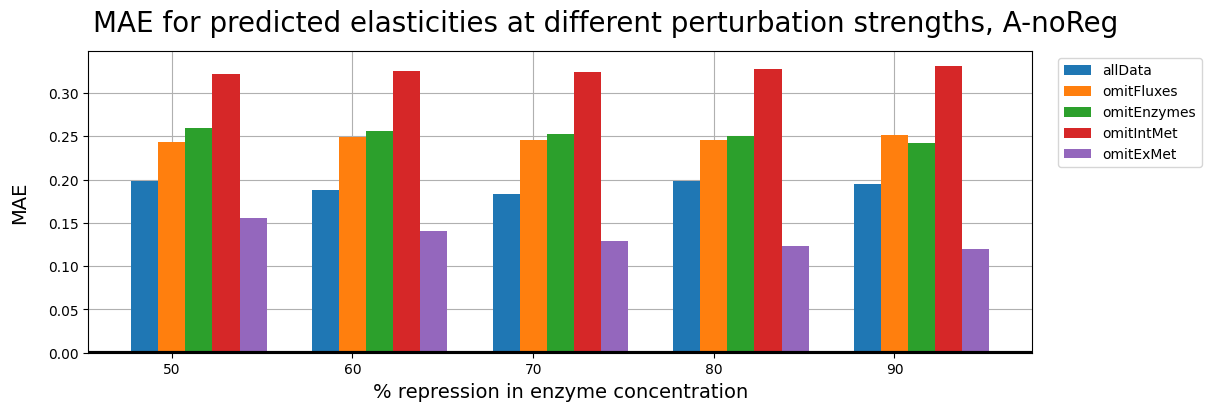

In [22]:
noReg_df = all_MAE_df_B[all_MAE_df_B['reg'] == 'noReg']
noReg_df['r'] = noReg_df['values'].round(3)
noReg_df.head()

species = list(all_MAE_df_B['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((noReg_df[noReg_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((noReg_df[noReg_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((noReg_df[noReg_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((noReg_df[noReg_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((noReg_df[noReg_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)

ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, A-noReg", size=20)


C:\Users\user\AppData\Local\Temp\ipykernel_30616\1207338315.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, A-reg1')

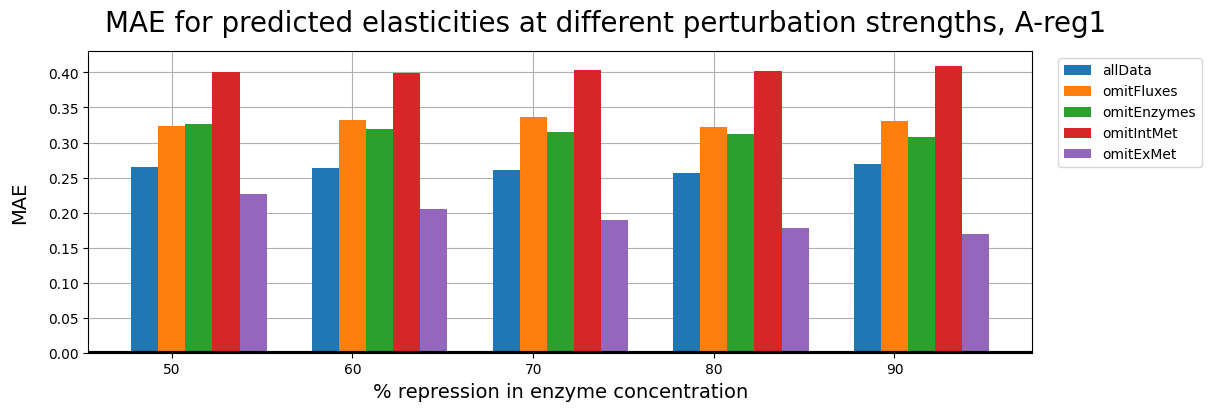

In [25]:
reg1_df = all_MAE_df_B[all_MAE_df_B['reg'] == 'reg1']
reg1_df['r'] = reg1_df['values'].round(3)
reg1_df.head()

species = list(all_MAE_df_B['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((reg1_df[reg1_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((reg1_df[reg1_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((reg1_df[reg1_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((reg1_df[reg1_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((reg1_df[reg1_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)

ax.set_xticks(x + width, ['50','60','70','80','90'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, A-reg1", size=20)


C:\Users\user\AppData\Local\Temp\ipykernel_30616\3763892287.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0.98, 'MAE for predicted elasticities at different perturbation strengths, A-reg2')

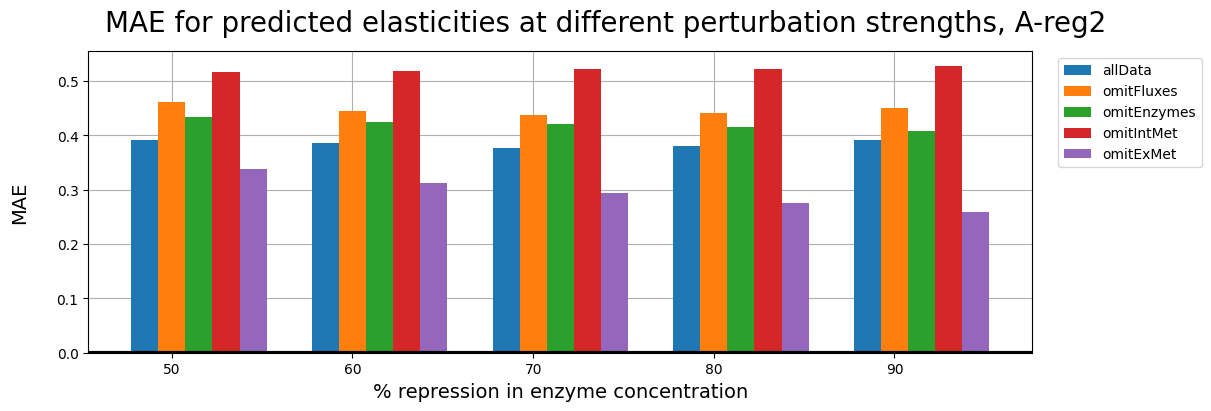

In [26]:
reg2_df = all_MAE_df_B[all_MAE_df_B['reg'] == 'reg2']
reg2_df['r'] = reg2_df['values'].round(3)
reg2_df.head()

species = list(all_MAE_df_B['perturbation'].unique()[0:5])[::-1]
MAE_means = {
    'allData': tuple((reg2_df[reg2_df['omit'] == 'allData']['values']).values[1:6])[::-1],
    'omitFluxes': tuple((reg2_df[reg2_df['omit'] == 'omitFluxes']['values']).values[1:6])[::-1],
    'omitEnzymes': tuple((reg2_df[reg2_df['omit'] == 'omitEnzymes']['values']).values[1:6])[::-1],
    'omitIntMet': tuple((reg2_df[reg2_df['omit'] == 'omitIntMet']['values']).values[1:6])[::-1],
    'omitExMet': tuple((reg2_df[reg2_df['omit'] == 'omitExMet']['values']).values[1:6])[::-1]
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['50','60','70','80','90'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("MAE for predicted elasticities at different perturbation strengths, A-reg2", size=20)


Text(0.5, 0.98, 'CRISPRa MAE for predicted elasticities at different perturbation strengths, A-noReg')

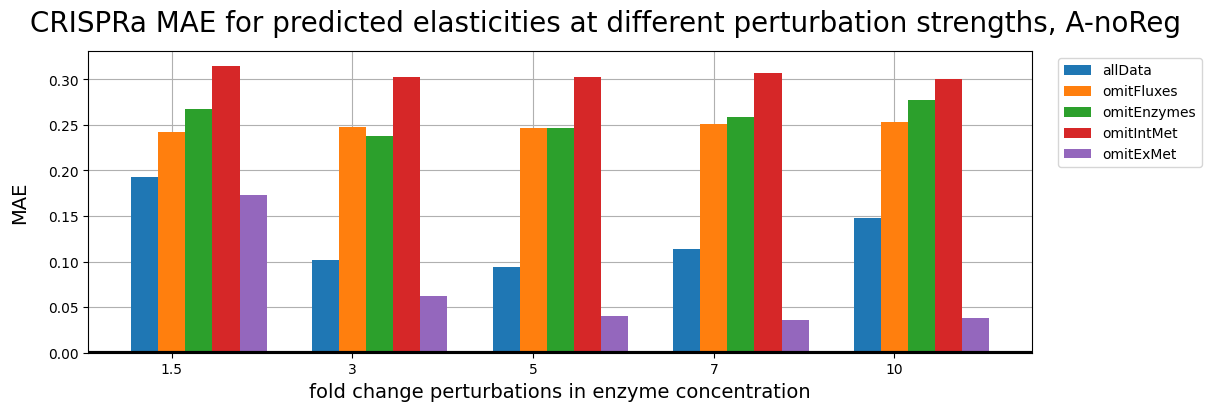

In [36]:
species = list(all_MAE_df_B['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((noReg_df[noReg_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((noReg_df[noReg_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((noReg_df[noReg_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((noReg_df[noReg_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((noReg_df[noReg_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, A-noReg", size=20)


Text(0.5, 0.98, 'CRISPRa MAE for predicted elasticities at different perturbation strengths, A-reg1')

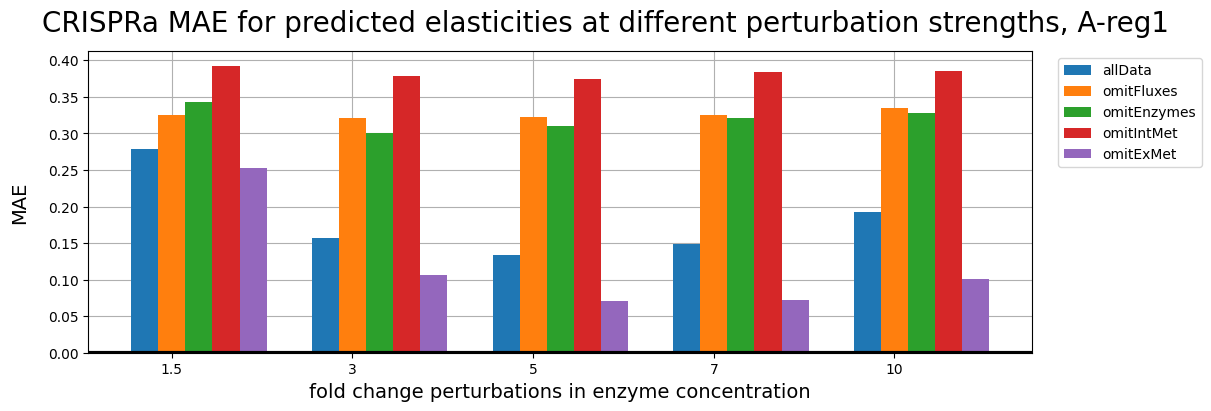

In [37]:
species = list(all_MAE_df_B['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((reg1_df[reg1_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((reg1_df[reg1_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((reg1_df[reg1_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((reg1_df[reg1_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((reg1_df[reg1_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, A-reg1", size=20)


Text(0.5, 0.98, 'CRISPRa MAE for predicted elasticities at different perturbation strengths, A-reg2')

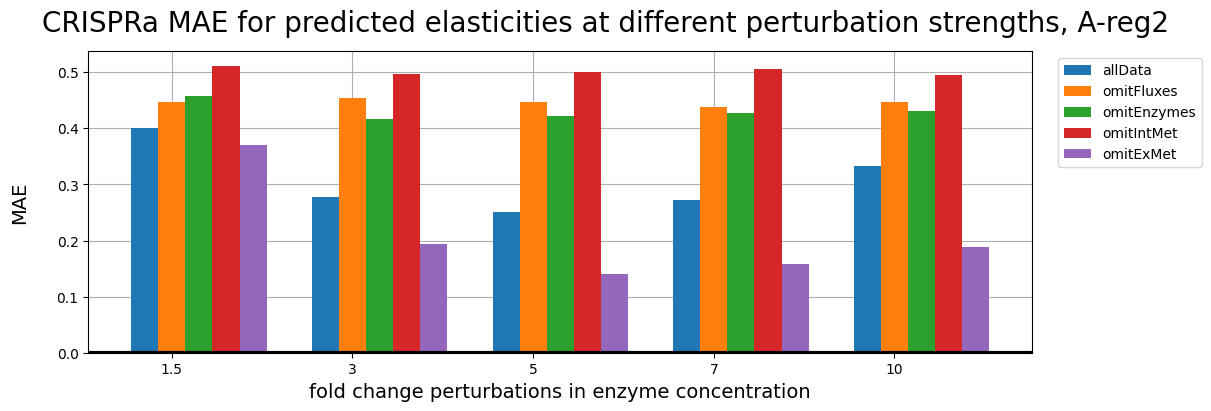

In [38]:
species = list(all_MAE_df_B['perturbation'].unique()[6:])
MAE_means = {
    'allData': tuple((reg2_df[reg2_df['omit'] == 'allData']['values']).values[6:]),
    'omitFluxes': tuple((reg2_df[reg2_df['omit'] == 'omitFluxes']['values']).values[6:]),
    'omitEnzymes': tuple((reg2_df[reg2_df['omit'] == 'omitEnzymes']['values']).values[6:]),
    'omitIntMet': tuple((reg2_df[reg2_df['omit'] == 'omitIntMet']['values']).values[6:]),
    'omitExMet': tuple((reg2_df[reg2_df['omit'] == 'omitExMet']['values']).values[6:])
}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in MAE_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
ax.set_xticks(x + width, ['1.5','3','5','7','10'])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change perturbations in enzyme concentration", size=14)
plt.ylabel("MAE\n", size=14)

fig.suptitle("CRISPRa MAE for predicted elasticities at different perturbation strengths, A-reg2", size=20)


## Comparing Spearman r coefficients pairwise to find significant differences

In [16]:
def plot_CI_comparisons(subplot, omitted_type, reg_level, CRISPRi=True, color='orange'):

    if CRISPRi: 
        df1 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']=='allData')][0:5]
        df2 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']==f'omit{omitted_type}')][0:5]

        x1 = np.linspace(90,50,5)
        x2 = np.linspace(90,50,5)

    else:
        df1 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']=='allData')][5:10]
        df2 = all_spr_df_B[(all_spr_df_B['reg']==reg_level) & (all_spr_df_B['omit']==f'omit{omitted_type}')][5:10]

        x1 = df1['perturbation']
        x2 = df2['perturbation']

    ymin1 = (df1['r'] - df1['lower']).values
    ymax1 = (df1['upper'] - df1['r']).values

    ymin2 = (df2['r'] - df2['lower']).values
    ymax2 = (df2['upper'] - df2['r']).values

    subplot.scatter(x1, 
                abs(df1['r']), alpha=0.8, s=40, zorder=1000, label='all data', 
                color='red')
    subplot.errorbar(x1, df1['r'], yerr=np.stack((ymin1, ymax1)), 
                 linestyle='None', color='red', zorder=100)

    subplot.scatter(x2, 
                abs(df2['r']), alpha=0.8, s=100, zorder=50, 
                label=f'omit {omitted_type}', c=color)
    subplot.errorbar(x2, df2['r'], yerr=np.stack((ymin2, ymax2)), 
                 elinewidth=6, linestyle='None', c=color, zorder=10,
                 alpha=0.8)

    subplot.grid(True, which='both', axis='both', zorder=0)
    subplot.set_ylim([0,1])
        

Text(0.5, 0.98, 'TopologyB--Comparing CRISPRi datasets with omitted data at different regulation levels')

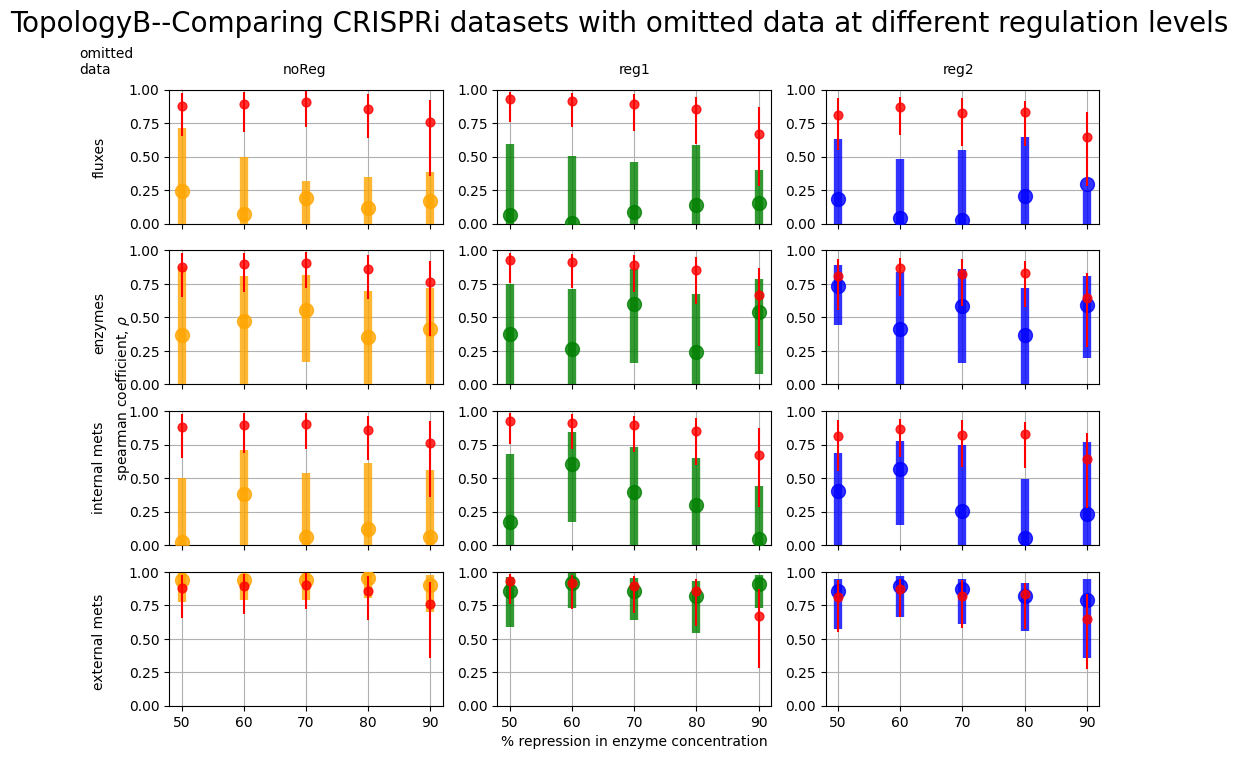

In [17]:
fig, ax = plt.subplots(4, 3, figsize=(12,8), sharex=True)
plot_CI_comparisons(ax[0,0], "Fluxes", "noReg")
plot_CI_comparisons(ax[0,1], "Fluxes", "reg1", color='green')
plot_CI_comparisons(ax[0,2], "Fluxes", "reg2", color='blue')

plot_CI_comparisons(ax[1,0], "Enzymes", "noReg")
plot_CI_comparisons(ax[1,1], "Enzymes", "reg1", color='green')
plot_CI_comparisons(ax[1,2], "Enzymes", "reg2", color='blue')

plot_CI_comparisons(ax[2,0], "IntMet", "noReg")
plot_CI_comparisons(ax[2,1], "IntMet", "reg1", color='green')
plot_CI_comparisons(ax[2,2], "IntMet", "reg2", color='blue')

plot_CI_comparisons(ax[3,0], "ExMet", "noReg")
plot_CI_comparisons(ax[3,1], "ExMet", "reg1", color='green')
plot_CI_comparisons(ax[3,2], "ExMet", "reg2", color='blue')

fig.text(0.05, 0.9, 'omitted\ndata')
fig.text(0.22, 0.9, 'noReg')
fig.text(0.5, 0.9, 'reg1')
fig.text(0.77, 0.9, 'reg2')

fig.text(0.07, 0.77, 'fluxes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.55, 'enzymes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.35, 'internal mets', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.13, 'external mets', rotation=90, rotation_mode='anchor')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration")
plt.ylabel(r"spearman coefficient, $\rho$")

fig.suptitle("TopologyB--Comparing CRISPRi datasets with omitted data at different regulation levels", size=20)


Text(0.5, 0.98, 'TopologyB--Comparing CRISPRa datasets with omitted data at different regulations levels')

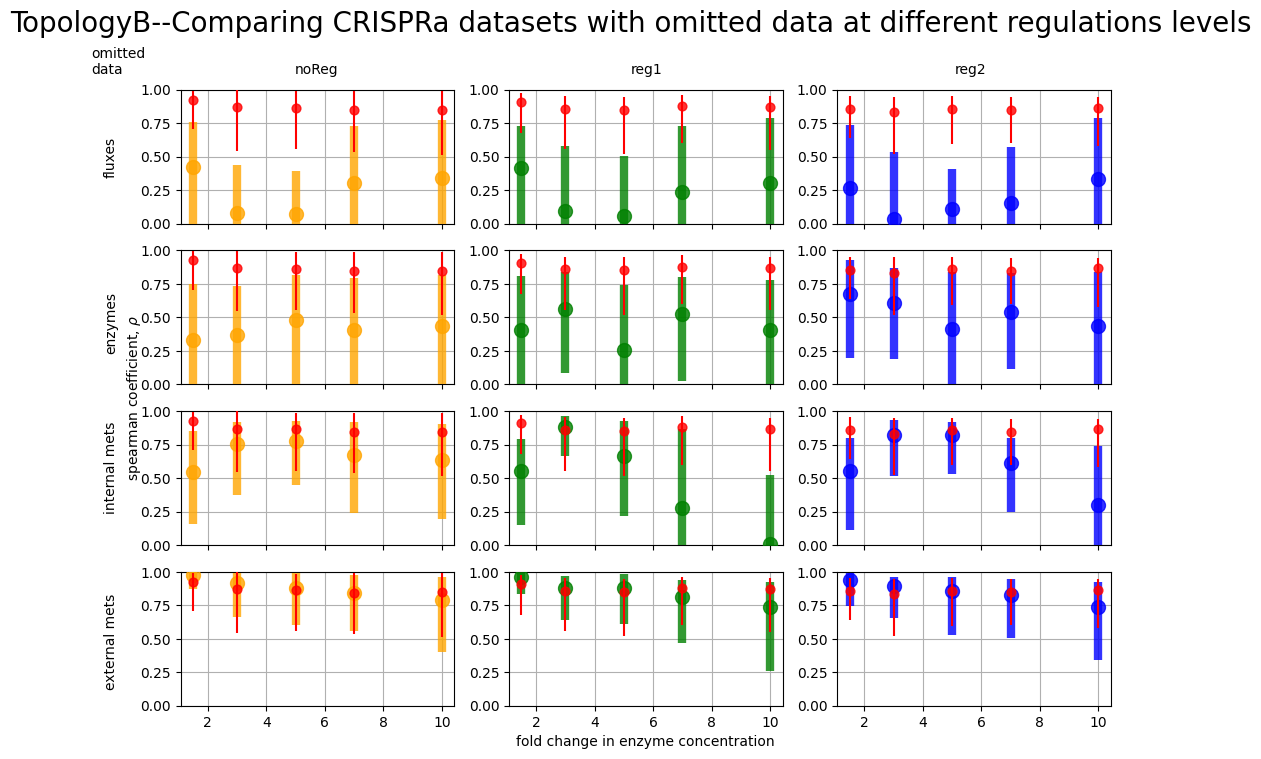

In [18]:
fig, ax = plt.subplots(4, 3, figsize=(12,8), sharex=True)
plot_CI_comparisons(ax[0,0], "Fluxes", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[0,1], "Fluxes", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[0,2], "Fluxes", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[1,0], "Enzymes", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[1,1], "Enzymes", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[1,2], "Enzymes", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[2,0], "IntMet", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[2,1], "IntMet", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[2,2], "IntMet", "reg2", CRISPRi=False, color='blue')

plot_CI_comparisons(ax[3,0], "ExMet", "noReg", CRISPRi=False)
plot_CI_comparisons(ax[3,1], "ExMet", "reg1", CRISPRi=False, color='green')
plot_CI_comparisons(ax[3,2], "ExMet", "reg2", CRISPRi=False, color='blue')


fig.text(0.05, 0.9, 'omitted\ndata')
fig.text(0.22, 0.9, 'noReg')
fig.text(0.5, 0.9, 'reg1')
fig.text(0.77, 0.9, 'reg2')

fig.text(0.07, 0.77, 'fluxes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.55, 'enzymes', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.35, 'internal mets', rotation=90, rotation_mode='anchor')
fig.text(0.07, 0.13, 'external mets', rotation=90, rotation_mode='anchor')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration")
plt.ylabel(r"spearman coefficient, $\rho$")

fig.suptitle("TopologyB--Comparing CRISPRa datasets with omitted data at different regulations levels", size=20)


## Comprehensive bar plots

In [2]:
B_noReg_df = all_spr_df_B[all_spr_df_B['reg'] == 'noReg']
B_noReg_df['r'] = B_noReg_df['r'].round(3)

B_reg1_df = all_spr_df_B[all_spr_df_B['reg'] == 'reg1']
B_reg1_df['r'] = B_reg1_df['r'].round(3)

B_reg2_df = all_spr_df_B[all_spr_df_B['reg'] == 'reg2']
B_reg2_df['r'] = B_reg2_df['r'].round(3)


NameError: name 'all_spr_df_B' is not defined

Text(0.5, 0.98, 'Comparing CRISPRi datasets with omitted data at different regulations levels, B-noReg')

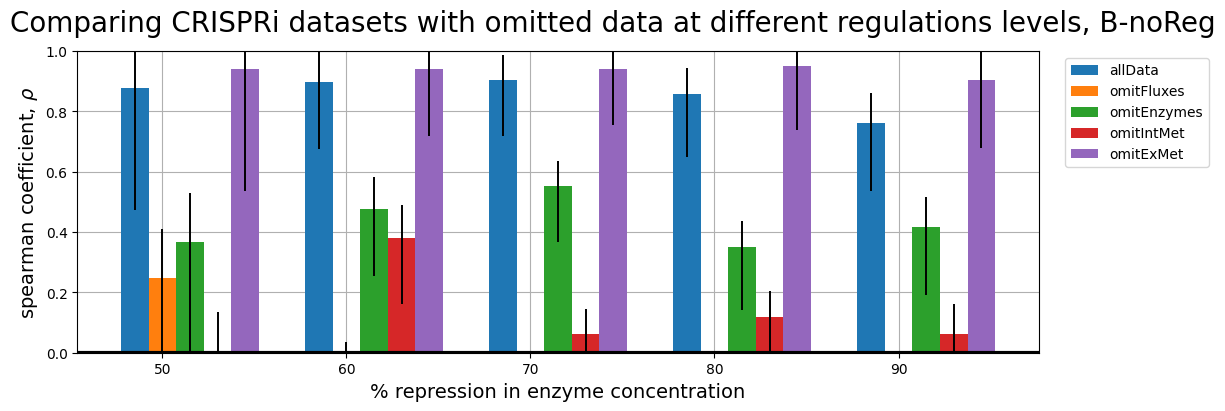

In [21]:
species = list(B_noReg_df['perturbation'].unique()[0:5])[::-1]
penguin_means = {
    'allData': tuple((B_noReg_df[B_noReg_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

ymin = (B_noReg_df['r'] - B_noReg_df['lower']).values[0:5]
ymax = (B_noReg_df['upper'] - B_noReg_df['r']).values[0:5]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, B-noReg", size=20)


Text(0.5, 0.98, 'Comparing CRISPRa datasets with omitted data at different regulations levels, B-noReg')

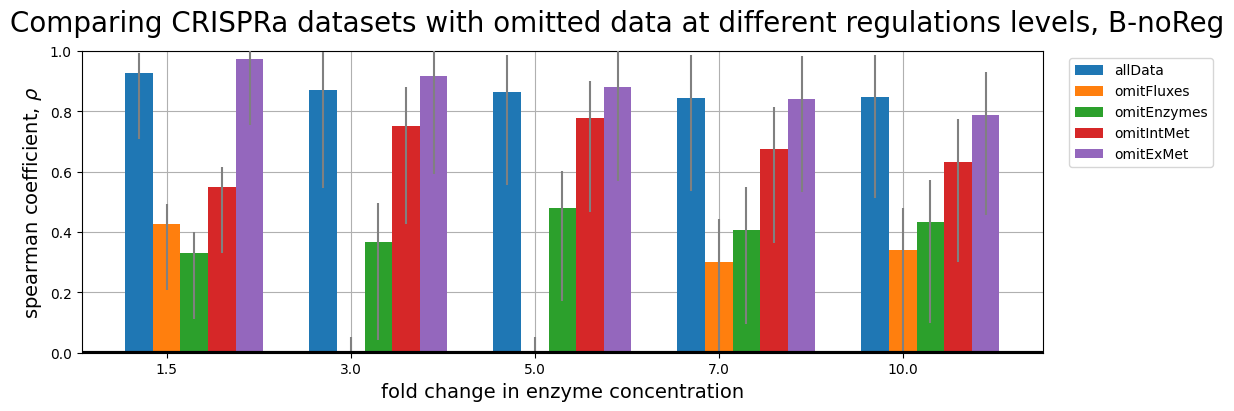

In [22]:
species = B_noReg_df['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((B_noReg_df[B_noReg_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((B_noReg_df[B_noReg_df['omit'] == 'omitExMet']['r']).values[5:10])
}

ymin = (B_noReg_df['r'] - B_noReg_df['lower']).values[5:10]
ymax = (B_noReg_df['upper'] - B_noReg_df['r']).values[5:10]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='gray', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, B-noReg", size=20)


Text(0.5, 0.98, 'Comparing CRISPRi datasets with omitted data at different regulations levels, B-reg1')

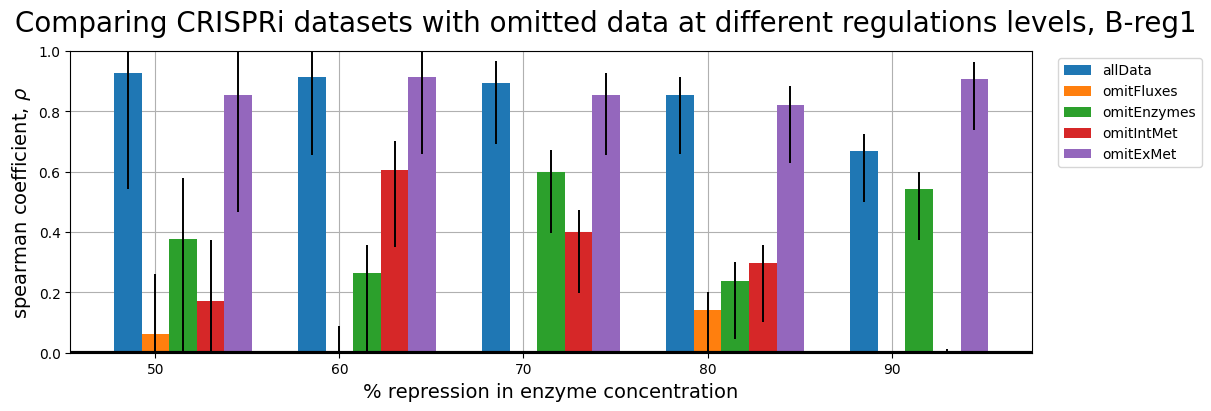

In [23]:
species = list(B_reg1_df['perturbation'].unique()[0:5])[::-1]
penguin_means = {
    'allData': tuple((B_reg1_df[B_reg1_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

ymin = (B_reg1_df['r'] - B_reg1_df['lower']).values[0:5]
ymax = (B_reg1_df['upper'] - B_reg1_df['r']).values[0:5]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, B-reg1", size=20)


Text(0.5, 0.98, 'Comparing CRISPRa datasets with omitted data at different regulations levels, B-reg1')

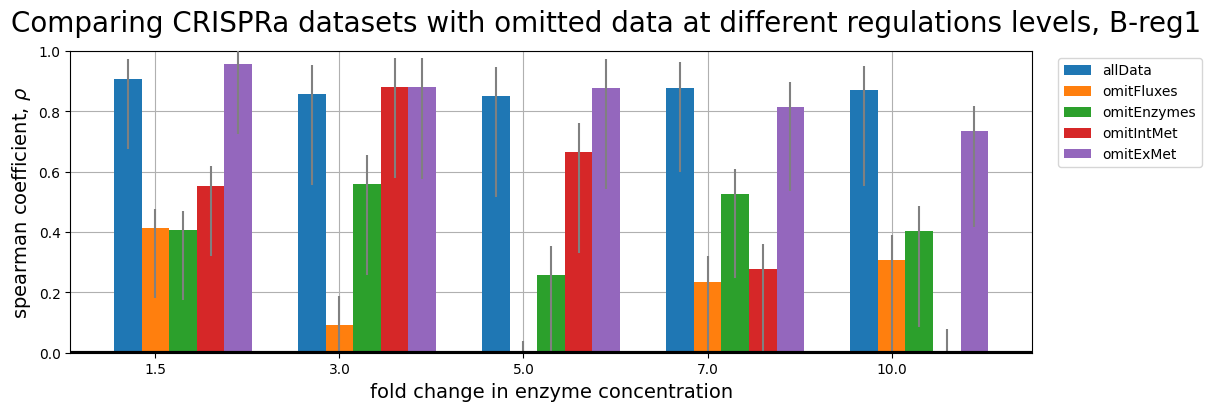

In [24]:
species = B_reg1_df['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((B_reg1_df[B_reg1_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((B_reg1_df[B_reg1_df['omit'] == 'omitExMet']['r']).values[5:10])
}

ymin = (B_reg1_df['r'] - B_reg1_df['lower']).values[5:10]
ymax = (B_reg1_df['upper'] - B_reg1_df['r']).values[5:10]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='gray', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, B-reg1", size=20)


Text(0.5, 0.98, 'Comparing CRISPRi datasets with omitted data at different regulations levels, B-reg2')

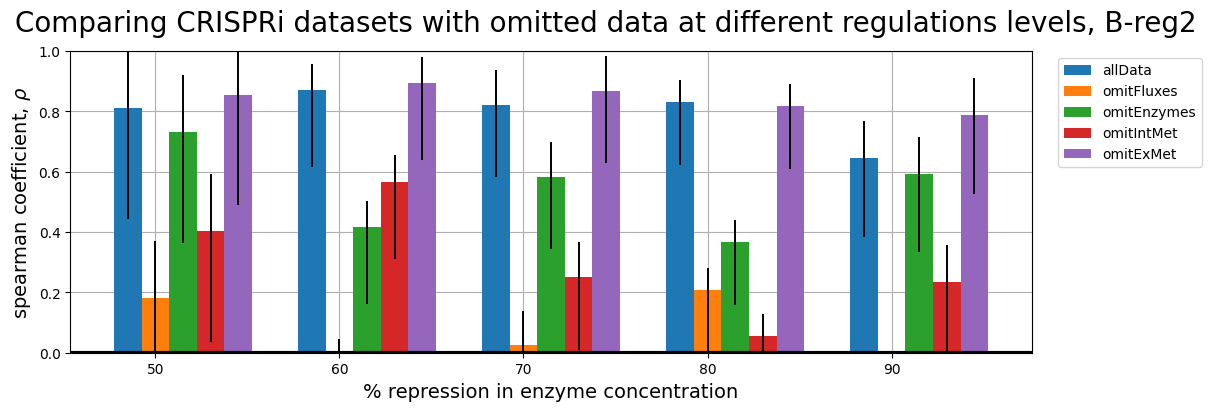

In [25]:
species = list(B_reg2_df['perturbation'].unique()[0:5])[::-1]
penguin_means = {
    'allData': tuple((B_reg2_df[B_reg2_df['omit'] == 'allData']['r']).values[0:5])[::-1],
    'omitFluxes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitFluxes']['r']).values[0:5])[::-1],
    'omitEnzymes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitEnzymes']['r']).values[0:5])[::-1],
    'omitIntMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitIntMet']['r']).values[0:5])[::-1],
    'omitExMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitExMet']['r']).values[0:5])[::-1]
}

ymin = (B_reg2_df['r'] - B_reg2_df['lower']).values[0:5]
ymax = (B_reg2_df['upper'] - B_reg2_df['r']).values[0:5]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='k', linewidth=1.4, zorder=100)
    multiplier += 1

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))
ax.set_xticks(x + width, ['50','60','70','80','90'])


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("% repression in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)

fig.suptitle("Comparing CRISPRi datasets with omitted data at different regulations levels, B-reg2", size=20)


Text(0.5, 0.98, 'Comparing CRISPRa datasets with omitted data at different regulations levels, B-reg2')

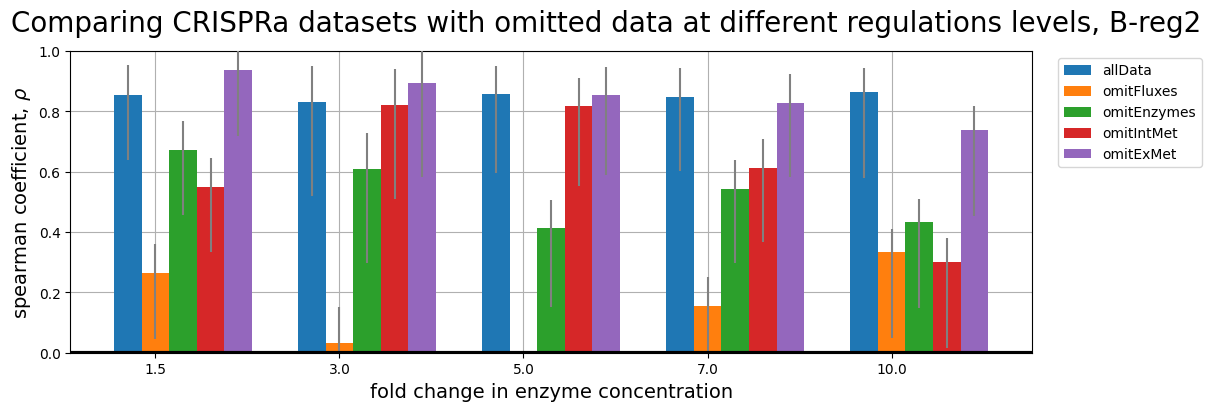

In [26]:
species = B_reg2_df['perturbation'].unique()[5:10]
penguin_means = {
    'allData': tuple((B_reg2_df[B_reg2_df['omit'] == 'allData']['r']).values[5:10]),
    'omitFluxes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitFluxes']['r']).values[5:10]),
    'omitEnzymes': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitEnzymes']['r']).values[5:10]),
    'omitIntMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitIntMet']['r']).values[5:10]),
    'omitExMet': tuple((B_reg2_df[B_reg2_df['omit'] == 'omitExMet']['r']).values[5:10])
}

ymin = (B_reg2_df['r'] - B_reg2_df['lower']).values[5:10]
ymax = (B_reg2_df['upper'] - B_reg2_df['r']).values[5:10]

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(12,4), layout='constrained', )

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=100)
    ax.errorbar(x + offset, measurement, yerr=np.stack((ymin, ymax)), 
                 linestyle='None', color='gray', zorder=100)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x + width, species)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True, which='both', axis='both', zorder=0)
plt.axhline(y=0, color='k', linewidth=3, zorder=500)
plt.ylim((0,1))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("fold change in enzyme concentration", size=14)
plt.ylabel(r"spearman coefficient, $\rho$", size=14)
fig.suptitle("Comparing CRISPRa datasets with omitted data at different regulations levels, B-reg2", size=20)


## Make tables of ranking correctness

In [3]:
os.chdir('../data/results/rankings/')

In [4]:
rank_file_list = [i for i in os.listdir() if "topologyB" in i]

rank_dfs = []
for file in rank_file_list:
    a = pd.read_csv(file)

    reg = file.split('_')[0].split('-')[1]
    omit = file.split('_')[1]

    a['reg'] = [reg]*len(a)
    a['omit'] = [omit]*len(a)
    rank_dfs.append(a)

all_rank_df_B = pd.concat(rank_dfs).drop('1.01x', axis=1)
all_rank_df_B

,v19,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x,reg,omit
0,1.0,v2,v15,v15,v2,v2,v2,v2,v2,v2,v2,v2,noReg,allData
1,2.0,v15,v2,v2,v15,v15,v15,v7,v15,v7,v15,v7,noReg,allData
2,3.0,v7,v21,v8,v7,v8,v7,v15,v7,v15,v7,v15,noReg,allData
3,4.0,v4,v8,v7,v8,v7,v21,v4,v4,v4,v4,v4,noReg,allData
4,5.0,v21,v7,v21,v21,v21,v8,v21,v21,v21,v21,v21,noReg,allData
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,15.0,v16,v2,v2,v10,v6,v4,v9,v16,v3,v14,v14,reg2,omitIntMet
15,16.0,v17,v5,v13,v11,v10,v18,v10,v11,v14,v17,v3,reg2,omitIntMet
16,17.0,v3,v13,v3,v16,v16,v2,v13,v3,v8,v5,v10,reg2,omitIntMet
17,18.0,v18,v3,v7,v3,v18,v11,v17,v12,v10,v8,v8,reg2,omitIntMet


In [5]:
os.chdir('../../../notebooks/')

In [6]:
topThree_df = all_rank_df_B[all_rank_df_B['v19'].isin([1, 2, 3])]

gt_ranks = all_rank_df_B['gt'].head(19)

rank_noReg = topThree_df[topThree_df['reg']=='noReg'].drop('gt', axis=1)
rank_reg1 = topThree_df[topThree_df['reg']=='reg1'].drop('gt', axis=1)
rank_reg2 = topThree_df[topThree_df['reg']=='reg2'].drop('gt', axis=1)

In [7]:
def condition(x):
    if x==0:
        return 0
    elif x<3:
        return 1
    else:
        return 2

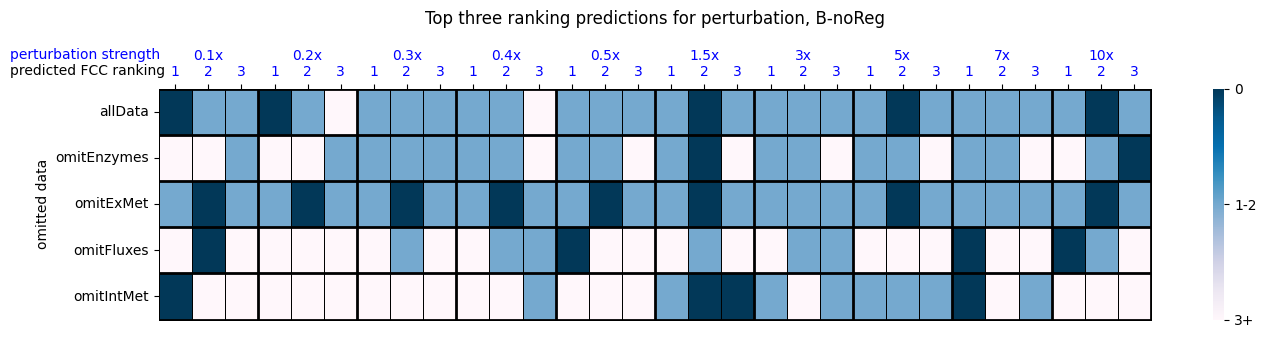

In [8]:
rank_noReg_sorted = rank_noReg.pivot(index='omit',columns='v19').drop('reg', axis=1)
gt_numbering_df = rank_noReg_sorted.applymap(lambda x: list(gt_ranks).index(x))
gt_numbering_df = gt_numbering_df.melt(ignore_index=False).reset_index()
gt_numbering_df['v19'] = gt_numbering_df['v19'].astype(int)
gt_numbering_df['difference'] = abs(gt_numbering_df['value'].subtract(gt_numbering_df['v19']))

yticklabels = []
for i in gt_numbering_df[None].unique():
    yticklabels = yticklabels+['\n1', i + '\n2', '\n3']

gt_differences_df = gt_numbering_df.pivot(index='omit',columns=[None, 'v19'],values='difference')
diff_color_df = gt_differences_df.applymap(lambda x: condition(x))

plt.figure(figsize=(16, 3))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.axes().xaxis.set_label_position('top')
ax = sns.heatmap(diff_color_df, linewidths=0.5, linecolor='black', clip_on=False, 
            cmap='PuBu_r', cbar_kws={"ticks":[0,1,2]})
plt.title("Top three ranking predictions for perturbation, B-noReg")
plt.xlabel('perturbation levels', c='w')
plt.text(-4.5, -0.65, "perturbation strength", c='b')
plt.text(-4.5, -0.3, "predicted FCC ranking")
plt.ylabel('omitted data')

plt.xticks(np.arange(0.5, 30.5),labels=yticklabels, rotation=0, c='b')

for i in range(10):
    plt.axvline(3*(i+1), linewidth=2, color='k')

for i in range(6):
    plt.axhline(i, linewidth=2, color='k')

c_bar = ax.collections[0].colorbar
c_bar.set_ticklabels(['0', '1-2', '3+'])
plt.gcf().axes[1].invert_yaxis()

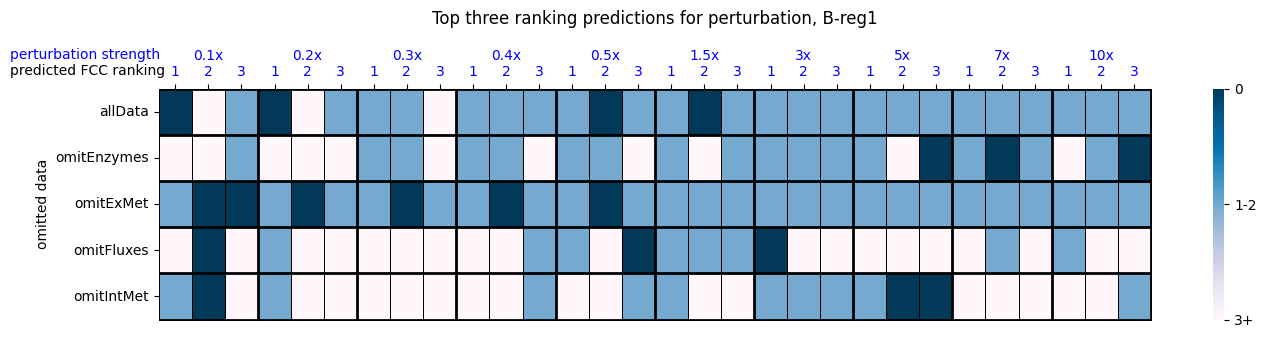

In [9]:
rank_reg1_sorted = rank_reg1.pivot(index='omit',columns='v19').drop('reg', axis=1)
gt_numbering_df = rank_reg1_sorted.applymap(lambda x: list(gt_ranks).index(x))
gt_numbering_df = gt_numbering_df.melt(ignore_index=False).reset_index()
gt_numbering_df['v19'] = gt_numbering_df['v19'].astype(int)
gt_numbering_df['difference'] = abs(gt_numbering_df['value'].subtract(gt_numbering_df['v19']))

yticklabels = []
for i in gt_numbering_df[None].unique():
    yticklabels = yticklabels+['\n1', i + '\n2', '\n3']

gt_differences_df = gt_numbering_df.pivot(index='omit',columns=[None, 'v19'],values='difference')
diff_color_df = gt_differences_df.applymap(lambda x: condition(x))

plt.figure(figsize=(16, 3))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.axes().xaxis.set_label_position('top')
ax = sns.heatmap(diff_color_df, linewidths=0.5, linecolor='black', clip_on=False, 
            cmap='PuBu_r', cbar_kws={"ticks":[0,1,2]})
plt.title("Top three ranking predictions for perturbation, B-reg1")
plt.xlabel('perturbation levels', c='w')
plt.text(-4.5, -0.65, "perturbation strength", c='b')
plt.text(-4.5, -0.3, "predicted FCC ranking")
plt.ylabel('omitted data')

plt.xticks(np.arange(0.5, 30.5),labels=yticklabels, rotation=0, c='b')

for i in range(10):
    plt.axvline(3*(i+1), linewidth=2, color='k')

for i in range(6):
    plt.axhline(i, linewidth=2, color='k')

c_bar = ax.collections[0].colorbar
c_bar.set_ticklabels(['0', '1-2', '3+'])
plt.gcf().axes[1].invert_yaxis()

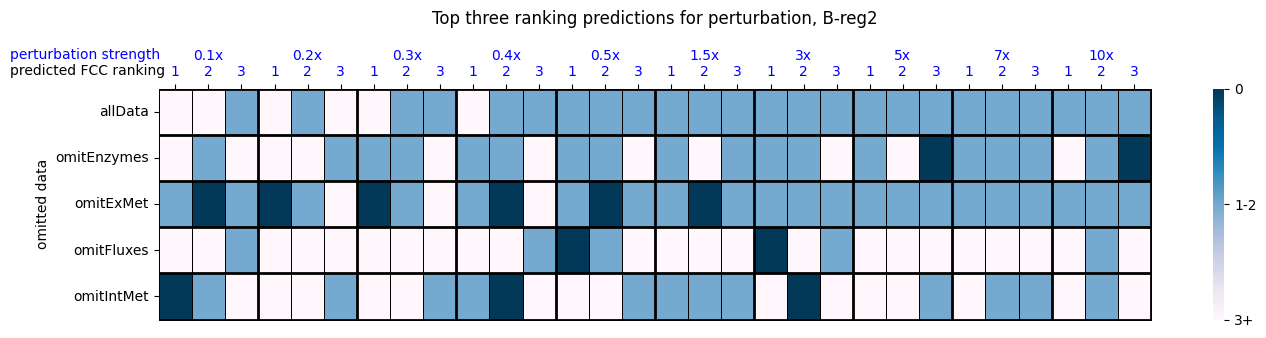

In [10]:
rank_reg2_sorted = rank_reg2.pivot(index='omit',columns='v19').drop('reg', axis=1)
gt_numbering_df = rank_reg2_sorted.applymap(lambda x: list(gt_ranks).index(x))
gt_numbering_df = gt_numbering_df.melt(ignore_index=False).reset_index()
gt_numbering_df['v19'] = gt_numbering_df['v19'].astype(int)
gt_numbering_df['difference'] = abs(gt_numbering_df['value'].subtract(gt_numbering_df['v19']))

yticklabels = []
for i in gt_numbering_df[None].unique():
    yticklabels = yticklabels+['\n1', i + '\n2', '\n3']

gt_differences_df = gt_numbering_df.pivot(index='omit',columns=[None, 'v19'],values='difference')
diff_color_df = gt_differences_df.applymap(lambda x: condition(x))

plt.figure(figsize=(16, 3))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.axes().xaxis.set_label_position('top')
ax = sns.heatmap(diff_color_df, linewidths=0.5, linecolor='black', clip_on=False, 
            cmap='PuBu_r', cbar_kws={"ticks":[0,1,2]})
plt.title("Top three ranking predictions for perturbation, B-reg2")
plt.xlabel('perturbation levels', c='w')
plt.text(-4.5, -0.65, "perturbation strength", c='b')
plt.text(-4.5, -0.3, "predicted FCC ranking")
plt.ylabel('omitted data')

plt.xticks(np.arange(0.5, 30.5),labels=yticklabels, rotation=0, c='b')

for i in range(10):
    plt.axvline(3*(i+1), linewidth=2, color='k')

for i in range(6):
    plt.axhline(i, linewidth=2, color='k')

c_bar = ax.collections[0].colorbar
c_bar.set_ticklabels(['0', '1-2', '3+'])
plt.gcf().axes[1].invert_yaxis()